In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Read train data cities
beijing = pd.read_csv('Beijing_labeled.csv')
shenyang = pd.read_csv('Shenyang_labeled.csv')
# Merge into one dataframe
data = pd.concat([beijing, shenyang])
print(data.shape)
data.head()

(2895, 11)


,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,cbwd_NE,cbwd_NW,cbwd_SE,PM_HIGH
0,4,-8.0,79.0,1026.0,-5.0,23.69,0.0,0,0,1,1.0
1,4,-11.0,85.0,1021.0,-9.0,105.93,1.1,0,0,1,0.0
2,4,-21.0,43.0,1030.0,-11.0,117.55,0.0,0,1,0,0.0
3,4,-25.0,33.0,1034.0,-12.0,39.35,0.0,1,0,0,0.0
4,4,-24.0,30.0,1034.0,-10.0,59.00,0.0,1,0,0,0.0


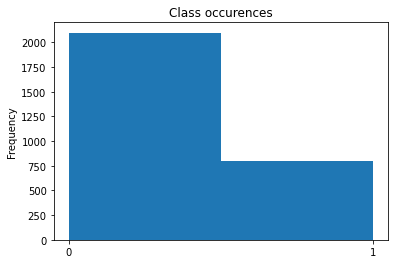

In [ ]:
# See if dataset is balanced
data['PM_HIGH'].plot.hist(bins=2, title="Class occurences", xticks=[0,1])
plt.show()

Training data is imbalanced. We should keep this in mind when selecting model.

In [ ]:
# Standardize features to zero mean and unit variance
features = data.drop('PM_HIGH', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.values)
data_norm = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
data_norm['PM_HIGH'] = data['PM_HIGH']
data_norm.head()

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,cbwd_NE,cbwd_NW,cbwd_SE,PM_HIGH
0,1.345351,-0.645127,1.641080,0.938370,-1.691890,0.039829,-0.099523,-0.353141,-0.633985,1.774138,1.0
1,1.345351,-0.857400,1.911613,0.442481,-2.022982,1.866585,2.183845,-0.353141,-0.633985,1.774138,0.0
2,1.345351,-1.564975,0.017880,1.335082,-2.188529,2.124694,-0.099523,-0.353141,1.577324,-0.563654,0.0
3,1.345351,-1.848005,-0.433009,1.731793,-2.271302,0.387677,-0.099523,2.831729,-0.633985,-0.563654,0.0
4,1.345351,-1.777247,-0.568276,1.731793,-2.105756,0.824153,-0.099523,2.831729,-0.633985,-0.563654,0.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


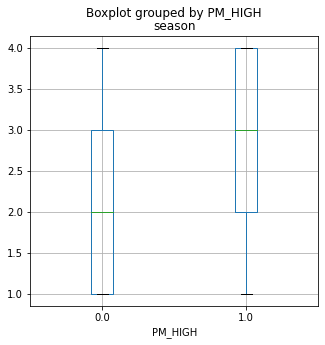

In [ ]:
# Explore features
data.boxplot(['season'], 'PM_HIGH', figsize=(5,  5))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7fdfde0790>,
      dtype=object)

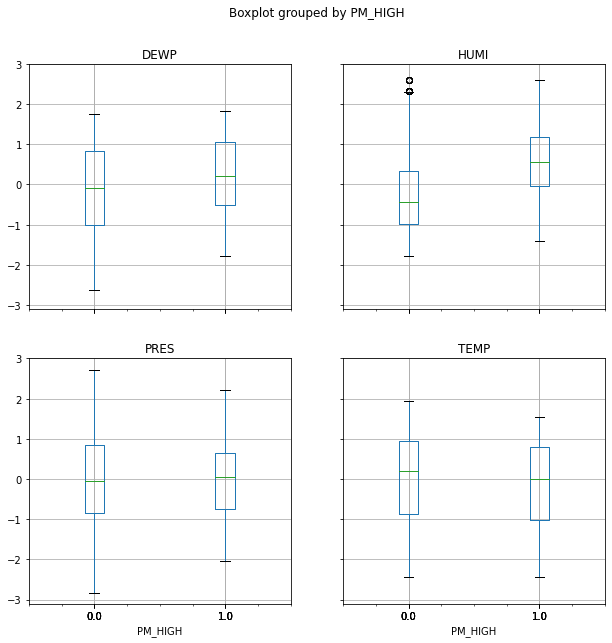

In [ ]:
data_norm.boxplot(['DEWP', 'HUMI','PRES','TEMP'], 'PM_HIGH', figsize=(10,  10))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


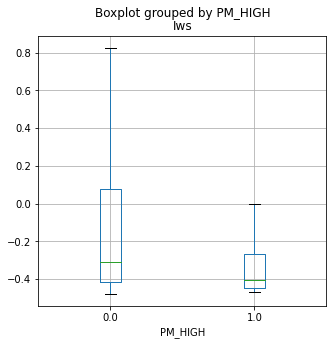

In [ ]:
data_norm.boxplot(['Iws'], 'PM_HIGH', figsize=(5,  5),showfliers=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


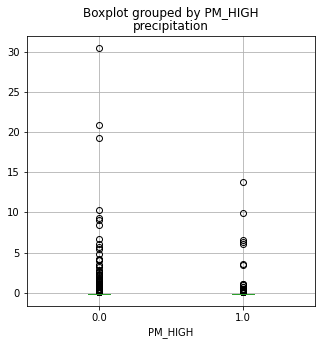

In [ ]:
data_norm.boxplot(['precipitation'], 'PM_HIGH', figsize=(5,  5), showfliers=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7fdf95be10>,
      dtype=object)

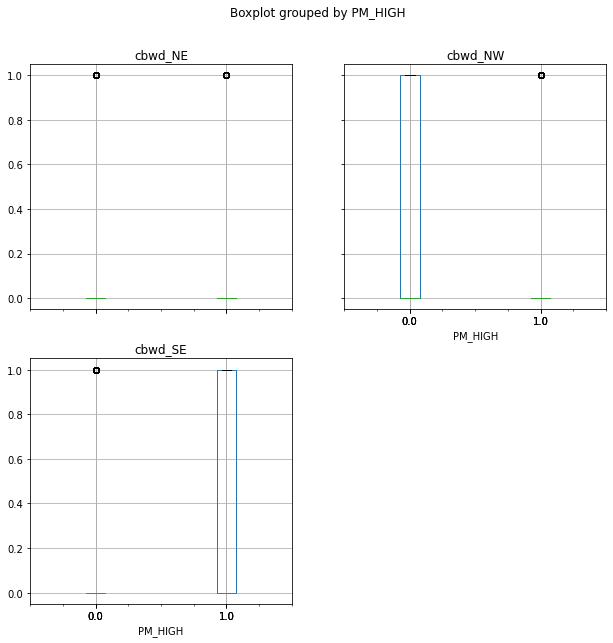

In [ ]:
data.boxplot(['cbwd_NE',	'cbwd_NW', 'cbwd_SE'], 'PM_HIGH', figsize=(10,  10), showfliers=True)

It seems as 'season', 'HUMI', 'Iws' are our best predictors. Could be worth checking out performance using only those.
It's hard to say from the boxplots if the categorical variable cbwd is good or not.

### Implementation

First let's try with all features

In [ ]:
# Make np arrays with training data
X_train = data_norm.drop('PM_HIGH', axis=1).to_numpy()
y_train = data_norm['PM_HIGH'].to_numpy().astype(np.int)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Create KNN classifier
class KNNClassifier():
  def __init__(self, k):
    self.k = k
    self.x_data = None
    self.y_data = None

  def euc_distance(self, x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2, axis=1))

  def fit(self, x, y):
    self.x_data = x
    self.y_data = y

  def predict(self, x):
    n_training_points = self.x_data.shape[0]

    if len(x.shape) == 1:
      x = np.expand_dims(x, axis=0)

    n_to_predict = x.shape[0]
    preds = np.zeros((n_to_predict,),dtype=np.int)

    # Make one prediction at a time
    for i in range(n_to_predict):
      x_i = np.expand_dims(x[i,:],axis=0)

      # Calculate distances between point x and all labelled x's
      rep = np.repeat(x_i, n_training_points, axis=0)
      distances = self.euc_distance(rep, self.x_data)

      # Sort in ascending order according to distance, and obtain index of sorted distances
      sorted_idxs = np.argsort(distances).astype(np.int)

      # Get the majority label of the first K entries
      k_neighbors_labels = self.y_data[sorted_idxs[:self.k]]
      label = np.bincount(k_neighbors_labels).argmax()
      preds[i] = label

    return preds

  def score(self, X, y):
    # Make predictions
    y_pred = self.predict(X)
    # Calculate score (weighted to adjust for class imbalance)
    p,r,f,_ = precision_recall_fscore_support(y, y_pred, average='weighted')
    a = accuracy_score(y, y_pred)
    return (p,r,f,a)
    

# Control if classifier works.
# With k=1 we should have perfect score when predicting on training data
model = KNNClassifier(k=1)
model.fit(X_train, y_train)
p, r, f, a = model.score(X_train, y_train)
print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Acc: {a:.3f}")

Precision: 1.000, Recall: 1.000, F1: 1.000, Acc: 1.000


In [ ]:
# Train for different K:s
def train_evaluate(X_train, y_train, X_val, y_val):
  ks = list(range(1,49,2))
  best_score = 0.0
  best_model = None
  for k in ks:
    # Fit model using training data
    model = KNNClassifier(k=k)
    model.fit(X_train, y_train)

    # Evaluate with validation data
    p, r, f, a = model.score(X_val, y_val)
    print(f"[VAL]: {k} neighbours - [Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Acc: {a:.3f}")
    if f > best_score:
      best_score = f
      best_model = model
  print(f"Best model: {best_model.k} neighbours")
  return best_model

best_model = train_evaluate(X_train, y_train, X_val, y_val)

[VAL]: 1 neighbours - [Precision: 0.708, Recall: 0.715, F1: 0.711, Acc: 0.715
[VAL]: 3 neighbours - [Precision: 0.736, Recall: 0.747, F1: 0.740, Acc: 0.747
[VAL]: 5 neighbours - [Precision: 0.763, Recall: 0.773, F1: 0.765, Acc: 0.773
[VAL]: 7 neighbours - [Precision: 0.768, Recall: 0.779, F1: 0.770, Acc: 0.779
[VAL]: 9 neighbours - [Precision: 0.771, Recall: 0.782, F1: 0.772, Acc: 0.782
[VAL]: 11 neighbours - [Precision: 0.777, Recall: 0.787, F1: 0.778, Acc: 0.787
[VAL]: 13 neighbours - [Precision: 0.775, Recall: 0.786, F1: 0.777, Acc: 0.786
[VAL]: 15 neighbours - [Precision: 0.770, Recall: 0.782, F1: 0.772, Acc: 0.782
[VAL]: 17 neighbours - [Precision: 0.770, Recall: 0.782, F1: 0.771, Acc: 0.782
[VAL]: 19 neighbours - [Precision: 0.765, Recall: 0.778, F1: 0.766, Acc: 0.778
[VAL]: 21 neighbours - [Precision: 0.771, Recall: 0.783, F1: 0.772, Acc: 0.783
[VAL]: 23 neighbours - [Precision: 0.781, Recall: 0.791, F1: 0.780, Acc: 0.791
[VAL]: 25 neighbours - [Precision: 0.781, Recall: 0.791, 

In [ ]:
# Read test data cities
guangzhou = pd.read_csv('Guangzhou_labeled.csv')
shanghai = pd.read_csv('Shanghai_labeled.csv')

# Standardize features to zero mean and unit variance
features_g = guangzhou.drop('PM_HIGH', axis=1)
scaled_features_g = scaler.fit_transform(features_g.values)
guangzhou_norm = pd.DataFrame(scaled_features_g, index=features_g.index, columns=features_g.columns)
guangzhou_norm['PM_HIGH'] = guangzhou['PM_HIGH']

features_s = shanghai.drop('PM_HIGH', axis=1)
scaled_features_s = scaler.fit_transform(features_s.values)
shanghai_norm = pd.DataFrame(scaled_features_s, index=features_s.index, columns=features_s.columns)
shanghai_norm['PM_HIGH'] = shanghai['PM_HIGH']

In [ ]:
def test_model(best_model, X_test_guan, y_test_guan, X_test_shang, y_test_shang):
  p, r, f, a = best_model.score(X_test_guan, y_test_guan)
  print(f"Guangzhou - [Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Acc: {a:.3f}")

  p, r, f, a = best_model.score(X_test_shang, y_test_shang)
  print(f"Shanghai - [Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Acc: {a:.3f}")

# Make np arrays 
X_test_guan = guangzhou_norm.drop('PM_HIGH', axis=1).to_numpy()
y_test_guan = guangzhou_norm['PM_HIGH'].to_numpy().astype(np.int)

X_test_shang = shanghai_norm.drop('PM_HIGH', axis=1).to_numpy()
y_test_shang = shanghai_norm['PM_HIGH'].to_numpy().astype(np.int)  

test_model(best_model, X_test_guan, y_test_guan, X_test_shang, y_test_shang)

Guangzhou - [Precision: 0.890, Recall: 0.774, F1: 0.823, Acc: 0.774
Shanghai - [Precision: 0.830, Recall: 0.764, F1: 0.794, Acc: 0.764


Now let's try only using three features which we could see were all quite important from the box plots, as well as the categorical variable cbwd because it was hard to see if it was important or not.

In [ ]:
feature_names = ['season', 'HUMI', 'Iws', 'cbwd_NE',	'cbwd_NW', 'cbwd_SE']

# Make np arrays with training data
X_train = data_norm[feature_names].to_numpy() # only keep feature_names features
y_train = data_norm['PM_HIGH'].to_numpy().astype(np.int)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

best_model = train_evaluate(X_train, y_train, X_val, y_val)

# Make test data
X_test_guan = guangzhou_norm[feature_names].to_numpy()
y_test_guan = guangzhou_norm['PM_HIGH'].to_numpy().astype(np.int)

X_test_shang = shanghai_norm[feature_names].to_numpy()
y_test_shang = shanghai_norm['PM_HIGH'].to_numpy().astype(np.int)  

test_model(best_model, X_test_guan, y_test_guan, X_test_shang, y_test_shang)


[VAL]: 1 neighbours - [Precision: 0.758, Recall: 0.765, F1: 0.761, Acc: 0.765
[VAL]: 3 neighbours - [Precision: 0.777, Recall: 0.785, F1: 0.779, Acc: 0.785
[VAL]: 5 neighbours - [Precision: 0.770, Recall: 0.780, F1: 0.772, Acc: 0.780
[VAL]: 7 neighbours - [Precision: 0.775, Recall: 0.785, F1: 0.777, Acc: 0.785
[VAL]: 9 neighbours - [Precision: 0.768, Recall: 0.779, F1: 0.770, Acc: 0.779
[VAL]: 11 neighbours - [Precision: 0.778, Recall: 0.789, F1: 0.779, Acc: 0.789
[VAL]: 13 neighbours - [Precision: 0.776, Recall: 0.786, F1: 0.778, Acc: 0.786
[VAL]: 15 neighbours - [Precision: 0.790, Recall: 0.798, F1: 0.791, Acc: 0.798
[VAL]: 17 neighbours - [Precision: 0.784, Recall: 0.794, F1: 0.785, Acc: 0.794
[VAL]: 19 neighbours - [Precision: 0.773, Recall: 0.785, F1: 0.774, Acc: 0.785
[VAL]: 21 neighbours - [Precision: 0.785, Recall: 0.796, F1: 0.784, Acc: 0.796
[VAL]: 23 neighbours - [Precision: 0.777, Recall: 0.789, F1: 0.776, Acc: 0.789
[VAL]: 25 neighbours - [Precision: 0.771, Recall: 0.783, 

We obtain pretty much at least the same performance when dropping the other features, indicating that they contained much noise.

### Result of the dummy classifier

In [ ]:
counts_guang = guangzhou['PM_HIGH'].value_counts().to_numpy()
print(counts_guang)
base_acc_guang = counts_guang[0]/np.sum(counts_guang)

counts_shang = shanghai['PM_HIGH'].value_counts().to_numpy()
print(counts_shang)
base_acc_shang = counts_shang[0]/np.sum(counts_shang)

print(f"guangzhou: you could get {base_acc_guang:.4f} in accuracy by predicting only 0")
print(f"shanghai: you could get {base_acc_shang:.4f} in accuracy by predicting only 0")

[1266   86]
[1218  133]
guangzhou: you could get 0.9364 in accuracy by predicting only 0
shanghai: you could get 0.9016 in accuracy by predicting only 0
